# Project 3: Smart Beta Portfolio and Portfolio Optimization

## Overview


Smart beta has a broad meaning, but we can say in practice that when we use the universe of stocks from an index, and then apply some weighting scheme other than market cap weighting, it can be considered a type of smart beta fund.  A Smart Beta portfolio generally gives investors exposure or "beta" to one or more types of market characteristics (or factors) that are believed to predict prices while giving investors a diversified broad exposure to a particular market. Smart Beta portfolios generally target momentum, earnings quality, low volatility, and dividends or some combination. Smart Beta Portfolios are generally rebalanced infrequently and follow relatively simple rules or algorithms that are passively managed.  Model changes to these types of funds are also rare requiring prospectus filings with US Security and Exchange Commission in the case of US focused mutual funds or ETFs.. Smart Beta portfolios are generally long-only, they do not short stocks.

In contrast, a purely alpha-focused quantitative fund may use multiple models or algorithms to create a portfolio. The portfolio manager retains discretion in upgrading or changing the types of models and how often to rebalance the portfolio in attempt to maximize performance in comparison to a stock benchmark.  Managers may have discretion to short stocks in portfolios.

Imagine you're a portfolio manager, and wish to try out some different portfolio weighting methods.

One way to design portfolio is to look at certain accounting measures (fundamentals) that, based on past trends, indicate stocks that produce better results.  


For instance, you may start with a hypothesis that dividend-issuing stocks tend to perform better than stocks that do not. This may not always be true of all companies; for instance, Apple does not issue dividends, but has had good historical performance.  The hypothesis about dividend-paying stocks may go something like this: 

Companies that regularly issue dividends may also be more prudent in allocating their available cash, and may indicate that they are more conscious of prioritizing shareholder interests.  For example, a CEO may decide to reinvest cash into pet projects that produce low returns.  Or, the CEO may do some analysis, identify that reinvesting within the company produces lower returns compared to a diversified portfolio, and so decide that shareholders would be better served if they were given the cash (in the form of dividends).  So according to this hypothesis, dividends may be both a proxy for how the company is doing (in terms of earnings and cash flow), but also a signal that the company acts in the best interest of its shareholders.  Of course, it's important to test whether this works in practice.


You may also have another hypothesis, with which you wish to design a portfolio that can then be made into an ETF.  You may find that investors may wish to invest in passive beta funds, but wish to have less risk exposure (less volatility) in their investments.  The goal of having a low volatility fund that still produces returns similar to an index may be appealing to investors who have a shorter investment time horizon, and so are more risk averse.

So the objective of your proposed portfolio is to design a portfolio that closely tracks an index, while also minimizing the portfolio variance.  Also, if this portfolio can match the returns of the index with less volatility, then it has a higher risk-adjusted return (same return, lower volatility).

Smart Beta ETFs can be designed with both of these two general methods (among others): alternative weighting and minimum volatility ETF.


## Instructions
Each problem consists of a function to implement and instructions on how to implement the function.  The parts of the function that need to be implemented are marked with a `# TODO` comment. After implementing the function, run the cell to test it against the unit tests we've provided. For each problem, we provide one or more unit tests from our `project_tests` package. These unit tests won't tell you if your answer is correct, but will warn you of any major errors. Your code will be checked for the correct solution when you submit it to Udacity.


### Load Packages

In [3]:
import pandas as pd
import numpy as np
import helper
import project_helper
import project_tests

## Market Data
### Load Data
For this universe of stocks, we'll be selecting large dollar volume stocks. We're using this universe, since it is highly liquid.

In [4]:
df = pd.read_csv('eod-quotemedia.csv')

percent_top_dollar = 0.2
high_volume_symbols = project_helper.large_dollar_volume_stocks(df, 'adj_close', 'adj_volume', percent_top_dollar)
df = df[df['ticker'].isin(high_volume_symbols)]

close = df.reset_index().pivot(index='date', columns='ticker', values='adj_close')
volume = df.reset_index().pivot(index='date', columns='ticker', values='adj_volume')
dividends = df.reset_index().pivot(index='date', columns='ticker', values='dividends')

### View Data
To see what one of these 2-d matrices looks like, let's take a look at the closing prices matrix.

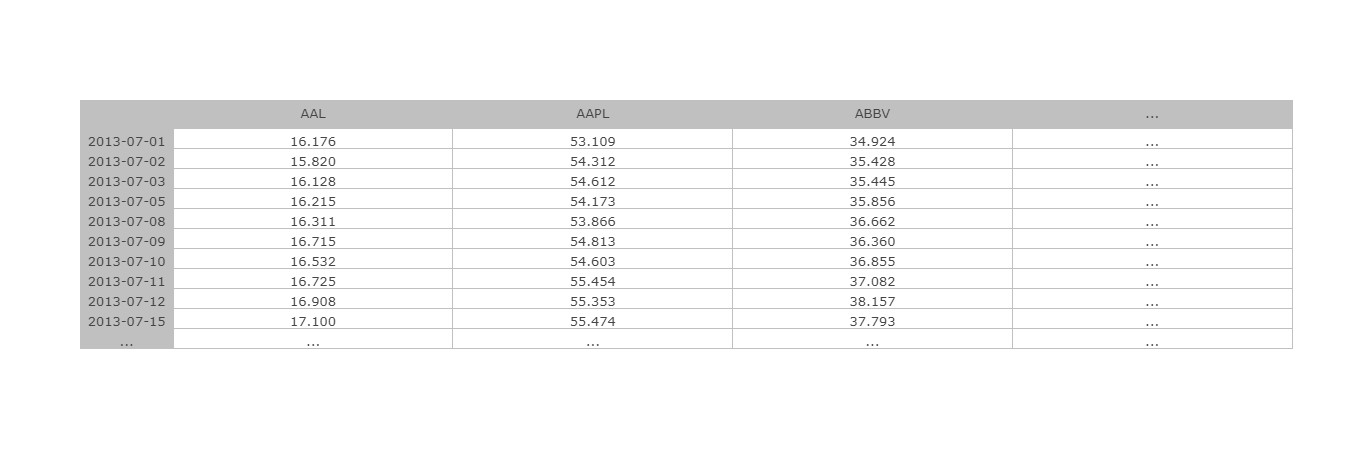

In [5]:
project_helper.print_dataframe(close)

# Part 1: Smart Beta Portfolio
In Part 1 of this project, you'll build a portfolio using dividend yield to choose the portfolio weights. A portfolio such as this could be incorporated into a smart beta ETF.  You'll compare this portfolio to a market cap weighted index to see how well it performs. 

Note that in practice, you'll probably get the index weights from a data vendor (such as companies that create indices, like MSCI, FTSE, Standard and Poor's), but for this exercise we will simulate a market cap weighted index.

## Index Weights
The index we'll be using is based on large dollar volume stocks. Implement `generate_dollar_volume_weights` to generate the weights for this index. For each date, generate the weights based on dollar volume traded for that date. For example, assume the following is close prices and volume data:
```
                 Prices
               A         B         ...
2013-07-08     2         2         ...
2013-07-09     5         6         ...
2013-07-10     1         2         ...
2013-07-11     6         5         ...
...            ...       ...       ...

                 Volume
               A         B         ...
2013-07-08     100       340       ...
2013-07-09     240       220       ...
2013-07-10     120       500       ...
2013-07-11     10        100       ...
...            ...       ...       ...
```
The weights created from the function `generate_dollar_volume_weights` should be the following:
```
               A         B         ...
2013-07-08     0.126..   0.194..   ...
2013-07-09     0.759..   0.377..   ...
2013-07-10     0.075..   0.285..   ...
2013-07-11     0.037..   0.142..   ...
...            ...       ...       ...
```

In [6]:
def generate_dollar_volume_weights(close, volume):
    """
    Generate dollar volume weights.

    Parameters
    ----------
    close : DataFrame
        Close price for each ticker and date
    volume : str
        Volume for each ticker and date

    Returns
    -------
    dollar_volume_weights : DataFrame
        The dollar volume weights for each ticker and date
    """
    assert close.index.equals(volume.index)
    assert close.columns.equals(volume.columns)
    
    #TODO: Implement function
    dollar_volume = close * volume
    dollar_volume_weights = dollar_volume.divide(dollar_volume.sum(axis=1), axis=0)
    return dollar_volume_weights

project_tests.test_generate_dollar_volume_weights(generate_dollar_volume_weights)

Tests Passed


### View Data
Let's generate the index weights using `generate_dollar_volume_weights` and view them using a heatmap.

In [7]:
index_weights = generate_dollar_volume_weights(close, volume)
project_helper.plot_weights(index_weights, 'Index Weights')

## Portfolio Weights
Now that we have the index weights, let's choose the portfolio weights based on dividend. You would normally calculate the weights based on trailing dividend yield, but we'll simplify this by just calculating the total dividend yield over time.

Implement `calculate_dividend_weights` to return the weights for each stock based on its total dividend yield over time. This is similar to generating the weight for the index, but it's using dividend data instead.
For example, assume the following is `dividends` data:
```
                 Prices
               A         B
2013-07-08     0         0
2013-07-09     0         1
2013-07-10     0.5       0
2013-07-11     0         0
2013-07-12     2         0
...            ...       ...
```
The weights created from the function `calculate_dividend_weights` should be the following:
```
               A         B
2013-07-08     NaN       NaN
2013-07-09     0         1
2013-07-10     0.333..   0.666..
2013-07-11     0.333..   0.666..
2013-07-12     0.714..   0.285..
...            ...       ...
```

In [8]:
def calculate_dividend_weights(dividends):
    """
    Calculate dividend weights.

    Parameters
    ----------
    ex_dividend : DataFrame
        Ex-dividend for each stock and date

    Returns
    -------
    dividend_weights : DataFrame
        Weights for each stock and date
    """
    #TODO: Implement function
    cum_dividend_yields = dividends.cumsum()
    dividend_weights = cum_dividend_yields.divide(cum_dividend_yields.sum(axis=1), axis=0)

    return dividend_weights

project_tests.test_calculate_dividend_weights(calculate_dividend_weights)

Tests Passed


### View Data
Just like the index weights, let's generate the ETF weights and view them using a heatmap.

In [9]:
etf_weights = calculate_dividend_weights(dividends)
project_helper.plot_weights(etf_weights, 'ETF Weights')

## Returns
Implement `generate_returns` to generate returns data for all the stocks and dates from price data. You might notice we're implementing returns and not log returns. Since we're not dealing with volatility, we don't have to use log returns.

In [10]:
def generate_returns(prices):
    """
    Generate returns for ticker and date.

    Parameters
    ----------
    prices : DataFrame
        Price for each ticker and date

    Returns
    -------
    returns : Dataframe
        The returns for each ticker and date
    """
    #TODO: Implement function
    returns = (prices - prices.shift(1)) / prices.shift(1)
    return returns

project_tests.test_generate_returns(generate_returns)

Tests Passed


### View Data
Let's generate the closing returns using `generate_returns` and view them using a heatmap.

In [11]:
returns = generate_returns(close)
project_helper.plot_returns(returns, 'Close Returns')

## Weighted Returns
With the returns of each stock computed, we can use it to compute the returns for an index or ETF. Implement `generate_weighted_returns` to create weighted returns using the returns and weights.

In [12]:
def generate_weighted_returns(returns, weights):
    """
    Generate weighted returns.

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    weights : DataFrame
        Weights for each ticker and date

    Returns
    -------
    weighted_returns : DataFrame
        Weighted returns for each ticker and date
    """
    assert returns.index.equals(weights.index)
    assert returns.columns.equals(weights.columns)
    
    #TODO: Implement function
    weighted_returns = returns * weights
    return weighted_returns

project_tests.test_generate_weighted_returns(generate_weighted_returns)

Tests Passed


### View Data
Let's generate the ETF and index returns using `generate_weighted_returns` and view them using a heatmap.

In [13]:
index_weighted_returns = generate_weighted_returns(returns, index_weights)
etf_weighted_returns = generate_weighted_returns(returns, etf_weights)
project_helper.plot_returns(index_weighted_returns, 'Index Returns')
project_helper.plot_returns(etf_weighted_returns, 'ETF Returns')

## Cumulative Returns
To compare performance between the ETF and Index, we're going to calculate the tracking error. Before we do that, we first need to calculate the index and ETF comulative returns. Implement `calculate_cumulative_returns` to calculate the cumulative returns over time given the returns.

In [14]:
def calculate_cumulative_returns(returns):
    """
    Calculate cumulative returns.

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date

    Returns
    -------
    cumulative_returns : Pandas Series
        Cumulative returns for each date
    """
    #TODO: Implement function
    cumulative_returns = np.cumprod(np.sum(returns,1)+1)
    return cumulative_returns

project_tests.test_calculate_cumulative_returns(calculate_cumulative_returns)

Tests Passed


### View Data
Let's generate the ETF and index cumulative returns using `calculate_cumulative_returns` and compare the two.

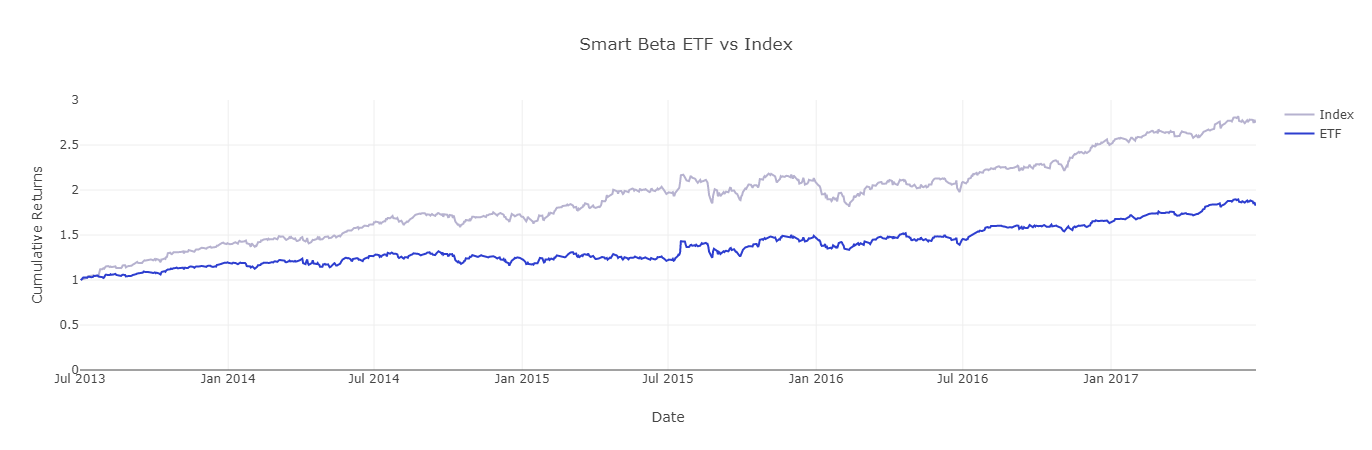

In [15]:
index_weighted_cumulative_returns = calculate_cumulative_returns(index_weighted_returns)
etf_weighted_cumulative_returns = calculate_cumulative_returns(etf_weighted_returns)
project_helper.plot_benchmark_returns(index_weighted_cumulative_returns, etf_weighted_cumulative_returns, 'Smart Beta ETF vs Index')

## Tracking Error
In order to check the performance of the smart beta portfolio, we can calculate the annualized tracking error against the index. Implement `tracking_error` to return the tracking error between the ETF and benchmark.

For reference, we'll be using the following annualized tracking error function:
$$ TE = \sqrt{252} * SampleStdev(r_p - r_b) $$

Where $ r_p $ is the portfolio/ETF returns and $ r_b $ is the benchmark returns.

_Note: When calculating the sample standard deviation, the delta degrees of freedom is 1, which is the also the default value._

In [16]:
def tracking_error(benchmark_returns_by_date, etf_returns_by_date):
    """
    Calculate the tracking error.

    Parameters
    ----------
    benchmark_returns_by_date : Pandas Series
        The benchmark returns for each date
    etf_returns_by_date : Pandas Series
        The ETF returns for each date

    Returns
    -------
    tracking_error : float
        The tracking error
    """
    assert benchmark_returns_by_date.index.equals(etf_returns_by_date.index)
    
    #TODO: Implement function
    tracking_error = np.sqrt(252) * np.std(etf_returns_by_date - benchmark_returns_by_date, ddof=1)
    return tracking_error

project_tests.test_tracking_error(tracking_error)

Tests Passed


### View Data
Let's generate the tracking error using `tracking_error`.

In [17]:
smart_beta_tracking_error = tracking_error(np.sum(index_weighted_returns, 1), np.sum(etf_weighted_returns, 1))
print('Smart Beta Tracking Error: {}'.format(smart_beta_tracking_error))

Smart Beta Tracking Error: 0.1020761483200753


# Part 2: Portfolio Optimization

Now, let's create a second portfolio.  We'll still reuse the market cap weighted index, but this will be independent of the dividend-weighted portfolio that we created in part 1.

We want to both minimize the portfolio variance and also want to closely track a market cap weighted index.  In other words, we're trying to minimize the distance between the weights of our portfolio and the weights of the index.

$Minimize \left [ \sigma^2_p + \lambda \sqrt{\sum_{1}^{m}(weight_i - indexWeight_i)^2} \right  ]$ where $m$ is the number of stocks in the portfolio, and $\lambda$ is a scaling factor that you can choose.

Why are we doing this? One way that investors evaluate a fund is by how well it tracks its index. The fund is still expected to deviate from the index within a certain range in order to improve fund performance.  A way for a fund to track the performance of its benchmark is by keeping its asset weights similar to the weights of the index.  We’d expect that if the fund has the same stocks as the benchmark, and also the same weights for each stock as the benchmark, the fund would yield about the same returns as the benchmark. By minimizing a linear combination of both the portfolio risk and distance between portfolio and benchmark weights, we attempt to balance the desire to minimize portfolio variance with the goal of tracking the index.


## Covariance
Implement `get_covariance_returns` to calculate the covariance of the `returns`. We'll use this to calculate the portfolio variance.

If we have $m$ stock series, the covariance matrix is an $m \times m$ matrix containing the covariance between each pair of stocks.  We can use [`Numpy.cov`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html) to get the covariance.  We give it a 2D array in which each row is a stock series, and each column is an observation at the same period of time. For any `NaN` values, you can replace them with zeros using the [`DataFrame.fillna`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) function.

The covariance matrix $\mathbf{P} = 
\begin{bmatrix}
\sigma^2_{1,1} & ... & \sigma^2_{1,m} \\ 
... & ... & ...\\
\sigma_{m,1} & ... & \sigma^2_{m,m}  \\
\end{bmatrix}$

In [18]:
def get_covariance_returns(returns):
    """
    Calculate covariance matrices.

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date

    Returns
    -------
    returns_covariance  : 2 dimensional Ndarray
        The covariance of the returns
    """
    #TODO: Implement function
    returns_covariance = np.cov(returns.T.fillna(0))
    return returns_covariance

project_tests.test_get_covariance_returns(get_covariance_returns)

Tests Passed


### View Data
Let's look at the covariance generated from `get_covariance_returns`.

In [19]:
covariance_returns = get_covariance_returns(returns)
covariance_returns = pd.DataFrame(covariance_returns, returns.columns, returns.columns)

covariance_returns_correlation = np.linalg.inv(np.diag(np.sqrt(np.diag(covariance_returns))))
covariance_returns_correlation = pd.DataFrame(
    covariance_returns_correlation.dot(covariance_returns).dot(covariance_returns_correlation),
    covariance_returns.index,
    covariance_returns.columns)

project_helper.plot_covariance_returns_correlation(
    covariance_returns_correlation,
    'Covariance Returns Correlation Matrix')

### portfolio variance
We can write the portfolio variance $\sigma^2_p = \mathbf{x^T} \mathbf{P} \mathbf{x}$

Recall that the $\mathbf{x^T} \mathbf{P} \mathbf{x}$ is called the quadratic form.
We can use the cvxpy function `quad_form(x,P)` to get the quadratic form.

### Distance from index weights
We want portfolio weights that track the index closely.  So we want to minimize the distance between them.
Recall from the Pythagorean theorem that you can get the distance between two points in an x,y plane by adding the square of the x and y distances and taking the square root.  Extending this to any number of dimensions is called the L2 norm.  So: $\sqrt{\sum_{1}^{n}(weight_i - indexWeight_i)^2}$  Can also be written as $\left \| \mathbf{x} - \mathbf{index} \right \|_2$.  There's a cvxpy function called [norm()](https://www.cvxpy.org/api_reference/cvxpy.atoms.other_atoms.html#norm)
`norm(x, p=2, axis=None)`.  The default is already set to find an L2 norm, so you would pass in one argument, which is the difference between your portfolio weights and the index weights.

### objective function
We want to minimize both the portfolio variance and the distance of the portfolio weights from the index weights.
We also want to choose a `scale` constant, which is $\lambda$ in the expression. 

$\mathbf{x^T} \mathbf{P} \mathbf{x} + \lambda \left \| \mathbf{x} - \mathbf{index} \right \|_2$


This lets us choose how much priority we give to minimizing the difference from the index, relative to minimizing the variance of the portfolio.  If you choose a higher value for `scale` ($\lambda$).

We can find the objective function using cvxpy `objective = cvx.Minimize()`.  Can you guess what to pass into this function?



### constraints
We can also define our constraints in a list.  For example, you'd want the weights to sum to one. So $\sum_{1}^{n}x = 1$.  You may also need to go long only, which means no shorting, so no negative weights.  So $x_i >0 $ for all $i$. you could save a variable as `[x >= 0, sum(x) == 1]`, where x was created using `cvx.Variable()`.

### optimization
So now that we have our objective function and constraints, we can solve for the values of $\mathbf{x}$.
cvxpy has the constructor `Problem(objective, constraints)`, which returns a `Problem` object.

The `Problem` object has a function solve(), which returns the minimum of the solution.  In this case, this is the minimum variance of the portfolio.

It also updates the vector $\mathbf{x}$.

We can check out the values of $x_A$ and $x_B$ that gave the minimum portfolio variance by using `x.value`

In [20]:
import cvxpy as cvx

def get_optimal_weights(covariance_returns, index_weights, scale=2.0):
    """
    Find the optimal weights.

    Parameters
    ----------
    covariance_returns : 2 dimensional Ndarray
        The covariance of the returns
    index_weights : Pandas Series
        Index weights for all tickers at a period in time
    scale : int
        The penalty factor for weights the deviate from the index 
    Returns
    -------
    x : 1 dimensional Ndarray
        The solution for x
    """
    assert len(covariance_returns.shape) == 2
    assert len(index_weights.shape) == 1
    assert covariance_returns.shape[0] == covariance_returns.shape[1]  == index_weights.shape[0]

    #TODO: Implement function
    
    # Number of index weights
    m = len(index_weights)
    
    x = cvx.Variable(m)
    
    portfolio_variance = cvx.quad_form(x, covariance_returns)
    
    distance_to_index = cvx.norm(x - index_weights, p=2)
    
    objective = cvx.Minimize(portfolio_variance + scale * distance_to_index)
    
    constraints = [x >= 0, sum(x) == 1]

    problem = cvx.Problem(objective, constraints)
    problem.solve()
    
    x_values = x.value
    
    return x_values

project_tests.test_get_optimal_weights(get_optimal_weights)

Tests Passed


## Optimized Portfolio
Using the `get_optimal_weights` function, let's generate the optimal ETF weights without rebalanceing. We can do this by feeding in the covariance of the entire history of data. We also need to feed in a set of index weights. We'll go with the average weights of the index over time.

In [21]:
raw_optimal_single_rebalance_etf_weights = get_optimal_weights(covariance_returns.values, index_weights.iloc[-1])
optimal_single_rebalance_etf_weights = pd.DataFrame(
    np.tile(raw_optimal_single_rebalance_etf_weights, (len(returns.index), 1)),
    returns.index,
    returns.columns)

With our ETF weights built, let's compare it to the index. Run the next cell to calculate the ETF returns and compare it to the index returns.

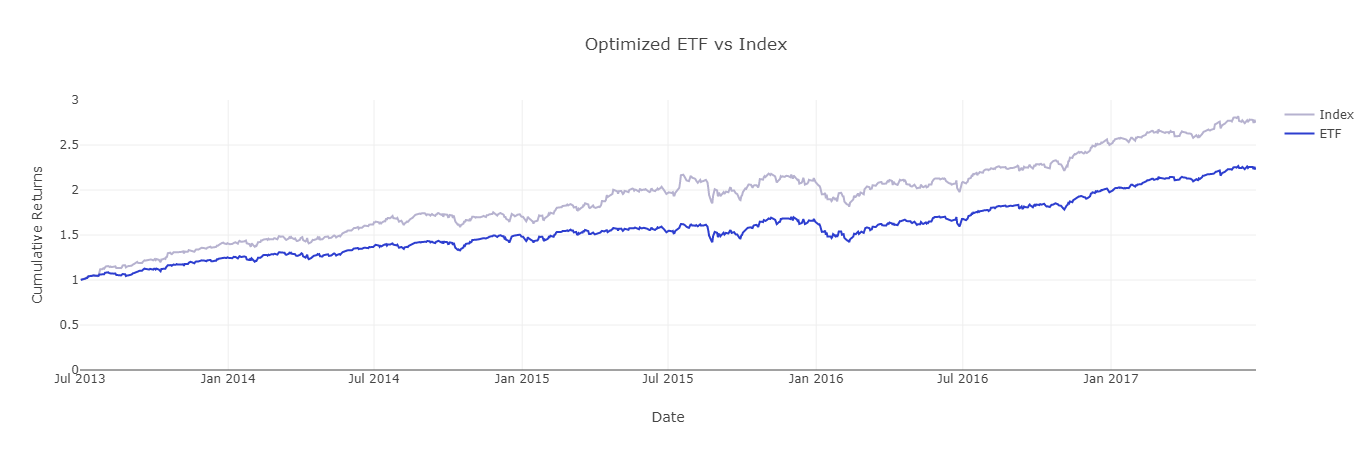

Optimized ETF Tracking Error: 0.05795012630412267


In [22]:
optim_etf_returns = generate_weighted_returns(returns, optimal_single_rebalance_etf_weights)
optim_etf_cumulative_returns = calculate_cumulative_returns(optim_etf_returns)
project_helper.plot_benchmark_returns(index_weighted_cumulative_returns, optim_etf_cumulative_returns, 'Optimized ETF vs Index')

optim_etf_tracking_error = tracking_error(np.sum(index_weighted_returns, 1), np.sum(optim_etf_returns, 1))
print('Optimized ETF Tracking Error: {}'.format(optim_etf_tracking_error))

## Rebalance Portfolio Over Time
The single optimized ETF portfolio used the same weights for the entire history. This might not be the optimal weights for the entire period. Let's rebalance the portfolio over the same period instead of using the same weights. Implement `rebalance_portfolio` to rebalance a portfolio.

Reblance the portfolio every n number of days, which is given as `shift_size`. When rebalancing, you should look back a certain number of days of data in the past, denoted as `chunk_size`. Using this data, compute the optimal weights using `get_optimal_weights` and `get_covariance_returns`.

In [23]:
def rebalance_portfolio(returns, index_weights, shift_size, chunk_size):
    """
    Get weights for each rebalancing of the portfolio.

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    index_weights : DataFrame
        Index weight for each ticker and date
    shift_size : int
        The number of days between each rebalance
    chunk_size : int
        The number of days to look in the past for rebalancing

    Returns
    -------
    all_rebalance_weights  : list of Ndarrays
        The ETF weights for each point they are rebalanced
    """
    assert returns.index.equals(index_weights.index)
    assert returns.columns.equals(index_weights.columns)
    assert shift_size > 0
    assert chunk_size >= 0
    
    #TODO: Implement function
    all_rebalance_weights = []

    for i in range(chunk_size, len(returns), shift_size):
        chunk = returns.iloc[i - chunk_size : i]
        covariance_returns = get_covariance_returns(chunk)
        optimal_weights = get_optimal_weights(covariance_returns, index_weights.iloc[i - 1])
        all_rebalance_weights.append(optimal_weights)
        
    return all_rebalance_weights

project_tests.test_rebalance_portfolio(rebalance_portfolio)

Tests Passed


Run the following cell to rebalance the portfolio using `rebalance_portfolio`.

In [24]:
chunk_size = 250
shift_size = 5
all_rebalance_weights = rebalance_portfolio(returns, index_weights, shift_size, chunk_size)

## Portfolio Turnover
With the portfolio rebalanced, we need to use a metric to measure the cost of rebalancing the portfolio. Implement `get_portfolio_turnover` to calculate the annual portfolio turnover. We'll be using the formulas used in the classroom:

$ AnnualizedTurnover =\frac{SumTotalTurnover}{NumberOfRebalanceEvents} * NumberofRebalanceEventsPerYear $

$ SumTotalTurnover =\sum_{t,n}{\left | x_{t,n} - x_{t+1,n} \right |} $ Where $ x_{t,n} $ are the weights at time $ t $ for equity $ n $.

$ SumTotalTurnover $ is just a different way of writing $ \sum \left | x_{t_1,n} - x_{t_2,n} \right | $

In [25]:
def get_portfolio_turnover(all_rebalance_weights, shift_size, rebalance_count, n_trading_days_in_year=252):
    """
    Calculage portfolio turnover.

    Parameters
    ----------
    all_rebalance_weights : list of Ndarrays
        The ETF weights for each point they are rebalanced
    shift_size : int
        The number of days between each rebalance
    rebalance_count : int
        Number of times the portfolio was rebalanced
    n_trading_days_in_year: int
        Number of trading days in a year

    Returns
    -------
    portfolio_turnover  : float
        The portfolio turnover
    """
    assert shift_size > 0
    assert rebalance_count > 0
    
    #TODO: Implement function
    sum_total_turnover = np.abs(np.diff(np.flip(all_rebalance_weights, axis=0), axis=0)).sum()
    number_rebalance_events_per_year = n_trading_days_in_year // shift_size
    annualized_turnover = (sum_total_turnover / rebalance_count) * number_rebalance_events_per_year
    
    return annualized_turnover

project_tests.test_get_portfolio_turnover(get_portfolio_turnover)

Tests Passed


Run the following cell to get the portfolio turnover from  `get_portfolio turnover`.

In [26]:
print(get_portfolio_turnover(all_rebalance_weights, shift_size, len(all_rebalance_weights) - 1))

16.594080020340048


That's it! You've built a smart beta portfolio in part 1 and did portfolio optimization in part 2. You can now submit your project.